In [3]:
import networkx as nx
import math
import numpy as np
#https://networkx.org/documentation/stable/tutorial.html

In [4]:
from functions_library import * 

def mySolve(G):
    n = len(G.nodes)
    k = math.log(n,10)
    for i in range(n):
        distances = nx.floyd_warshall(G, weight='weight')
        farthest_node = int(max(distances[i], key=distances[i].get))
        if farthest_node > k:
            G.add_edge(i,farthest_node)
    pos = nx.circular_layout(G)
    nx.draw(G,pos=pos)
    return(G)
    #subG = G.subgraph(range(v,farthest_node+1))

# Binary Search

In [95]:
# demand-aware binary search
def construct_binary_search(G):
    """constructs edges to enable binary search
    
    Args: 
        G: Graph in Ring (or any structure)
        
    Returns:
        G: Graph, with edges for binary search
    """
    for i in range(len(G.nodes)):
        binaryGUID = list(intToBin(i,len(G.nodes)))
        for j in range(1,len(binaryGUID)+1):
            binaryGUID = list(intToBin(i,len(G.nodes)))
            binaryGUID[-j] = str((int(binaryGUID[-j]) + 1) % 2)
            peer = binToInt(binaryGUID,len(G.nodes))
            G.add_edge(i,peer)
    return G


def construct_demand_aware_binary_search2(G,demandMatrix):
    """Constructs edges in a ring graph, to enable demand aware binary search"""
    copyDemandMatrix = demandMatrix
    
    maxEdge = np.argmax(copyDemandMatrix)
    #convert index to position
    row = math.floor(maxEdge/len(copyDemandMatrix))
    col = maxEdge % len(copyDemandMatrix)
    
    # If demand the same for all, do binary search
    if copyDemandMatrix[row][col] == round(1/(len(copyDemandMatrix)*(len(copyDemandMatrix)-1)),8):
        construct_binary_search(G)
        return G
    
    listOfNodes = list(G.nodes) 
    k = math.floor(math.log(len(listOfNodes),2))
    
    # Rearrange binary search to upgrade graph
    for i in range(len(copyDemandMatrix)):
        #copyDemandMatrix[i][1:len(copyDemandMatrix)-1]
        lastEdge = (i+math.ceil(len(copyDemandMatrix)/2)-1) % len(copyDemandMatrix)
        G.add_edge(i,lastEdge)
        
        frontNode = i
        backNode = len(G.nodes)-1 + (i % len(G.nodes)) +1
        for j in range(2,k):
            costFront = calc_totalTrafficCost_single_node(i,listOfNodes[frontNode:lastEdge+1],demandMatrix,G)
            costBack = calc_totalTrafficCost_single_node(i,listOfNodes[lastEdge:backNode],demandMatrix,G)
            if costFront > costBack:
                backNode = lastEdge
                lastEdge = lastEdge-math.ceil(len(listOfNodes)/(2**j))
                G.add_edge(i,lastEdge)
            else:
                frontNode = lastEdge
                lastEdge = lastEdge+math.floor(len(listOfNodes)/(2**j))
                
                G.add_edge(i,lastEdge)
    return G


# Demand Aware BS
def helper(G,D,v,nodesfrom_v,counter,lastAddedNode):
    if (len(G.edges(v)) == math.log(len(G.nodes),2)+2):
        return G
    if counter >= math.log(len(G.nodes),2):
        return G
    temp = lastAddedNode
    nodes = list(G.nodes)
    demandfrom_v = D
    if counter == 0:
        nodesfrom_v = nodes[(v+1 % (len(nodes)-1)):]
        nodesfrom_v += nodes[:(v+1 % (len(nodes)-1))]
        demandfrom_v = list(D[v][(v+1 % (len(nodes)-1)):])
        demandfrom_v += list(D[v][:(v+1 % (len(nodes)-1))])
    
    
    temp_demand = 0
    for u in nodesfrom_v:
        if u != v and (len(G.edges(u)) != (math.log(len(G.nodes),2)+2)):
            if temp_demand >= round(sum(demandfrom_v[lastAddedNode:])/2,8):
                temp = nodesfrom_v.index(u)
                G.add_edge(v,u)
                break
            else:
                temp = nodesfrom_v.index(u)
                temp_demand += demandfrom_v[temp]
    counter += 1
    
    #pick larger half
    if len(demandfrom_v[temp:]) > len(demandfrom_v[:temp]):
        helper(G,demandfrom_v[temp:],v,nodesfrom_v[temp:],counter,temp)
    else:
        helper(G,demandfrom_v[:temp],v,nodesfrom_v[:temp],counter,temp)
    
def construct_demand_aware_binary_search(G,D):
    for v in G.nodes:
        helper(G,D,v,list(G.nodes),0,0)
    return G

# Testing

In [114]:
# Init size for Ring, 2^k
k = 6


#print(demandMatrix)

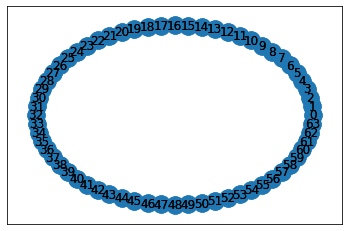

In [115]:
#D[0][4] = 1
#D[0][8] = 1
#D_bs[2][8] = 1

G = init_ring(2**k)
D_bs = init_uniformDemand_matrix(G)
G_bs = construct_binary_search(G)


G = init_ring(2**k)
D = init_uniformDemand_matrix_symmetric(G)
G_da_bs = construct_demand_aware_binary_search(G,D)
#pos = nx.circular_layout(G)
#nx.draw_networkx(G,pos=pos,with_labels=True)

In [116]:
print(print(G_bs.edges(0)))
print(print(G_da_bs.edges(0)))
print(calc_cost(G_bs,D_bs))
print(calc_cost(G_da_bs,D_bs))

[(0, 1), (0, 63), (0, 2), (0, 4), (0, 8), (0, 16), (0, 32)]
None
[(0, 1), (0, 63), (0, 33), (0, 18), (0, 10), (0, 31), (0, 46), (0, 53)]
None
2.6359034200000466
2.3720154600000356


# Plotting

1
2
3
4
5
6
7
8
9
10
11


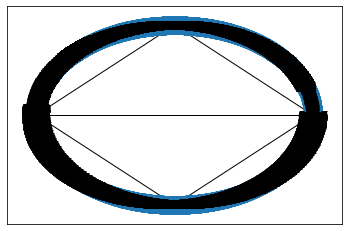

In [65]:
binarySearchOutput = []
demandAwarebinarySearchOutput = []
for k in range(1,12):
    G = init_ring(2**k)
    print(k)
    D_bs = init_uniformDemand_matrix(G)
    D_dabs = init_uniformDemand_matrix_symmetric(G)
    G_bs = construct_binary_search(G)
    G = init_ring(2**k)
    G_da_bs = construct_demand_aware_binary_search(G,D_dabs)
    binarySearchOutput.append(calc_cost(G_bs,D_bs))
    demandAwarebinarySearchOutput.append(calc_cost(G_da_bs,D_bs))

In [6]:
#print(calc_totalTrafficCost_single_node(i,listOfNodes[1:10],demandMatrix,G))

NameError: name 'i' is not defined

In [ ]:
demandMatrix[0][1] = 1
print(construct_binary_search(G))
print(~-1)

In [ ]:
#Testing
print(G.number_of_edges(),2**(k+1))

#Test if every node can reach every other in max. log(n) hops
distances = nx.floyd_warshall(G, weight='weight')
for i in range(2**k):
    maxKey = max(distances[i], key=distances[i].get)
    tempMax = distances[i][maxKey]
print(k >= tempMax,tempMax)


# Proof

In [ ]:
def init_matrix(k):
    n = 2**k
    matr_graph = []
    
    temp = []
    temp.append(bin(1),bin(n))
    temp.append(['0b' + ''])
    matr_graph.append((bin(0),[bin(1),bin(n)]))
    
    
    for i in range(1,n-1):
        temp = []
        temp.append(bin(i))
        temp.append(bin(i-1))
        temp.append(bin(i+1))
        matr_graph.append((temp[0],temp[1:]))
    print(matr_graph)

In [ ]:
init_matrix(3)

In [ ]:
bin(7)